## Init

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
# %%capture
!pip install -q efficientnet

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
# import pickle
import scipy.io
import tarfile
# import csv
# # import sys
import os
import tensorflow as tf
# import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
# from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    LearningRateScheduler,
    ModelCheckpoint,
    EarlyStopping
)
# from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
import efficientnet.tfkeras as efn
from sklearn.model_selection import train_test_split
import PIL
# from PIL import ImageOps, ImageFilter

In [4]:
os.chdir("/content/drive/MyDrive/3_XuLyAnh_Flowers")
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1tU35xhAZwBdemxnc1j9Q3JzeU3wbyFMK/3_XuLyAnh_Flowers'

In [5]:
EPOCHS        = 5
BATCH_SIZE    = 8
LR_step1      = 1e-3
LR_step2      = 1e-4
LR_step3      = 1e-5
VAL_SPLIT     = 0.2
CLASS_NUM     = 15       #102
IMG_SIZE      = 250       # 250    # (725*500)
IMG_CHANNELS  = 3
input_shape   = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
RANDOM_SEED   = 42

## Data

### Load Data

In [ ]:
# # Đường dẫn đến tệp .tgz cần giải nén
# file_path = os.path.join(os.getcwd(), '102flowers.tgz')

# # Mở tệp .tgz
# with tarfile.open(file_path, 'r:gz') as tar:
#     # Giải nén toàn bộ nội dung của tệp .tgz vào thư mục hiện tại
#     tar.extractall()

In [6]:
DATA_PATH = os.getcwd()
PATH = os.getcwd() + "/jpg/"

In [7]:
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]


df = pd.DataFrame()
df['Id'] = sorted(get_all_filenames(DATA_PATH + '/102flowers.tgz'))

# load file label:  label (1 -> 102) == -1 ==>  (0 -> 101)
df['Category'] = scipy.io.loadmat(DATA_PATH + '/imagelabels.mat')['labels'][0] - 1
df['Category'] = df['Category'].astype(str)

In [8]:
top_15_categories = ['48', '76', '42', '72', '89', '73', '81', '95', '88', '77', '37', '39', '83', '96', '74']

In [9]:
# Lọc DataFrame ban đầu
df_15 = df[df['Category'].isin(top_15_categories)]

In [ ]:
# df.head(5)

### Visualization Data

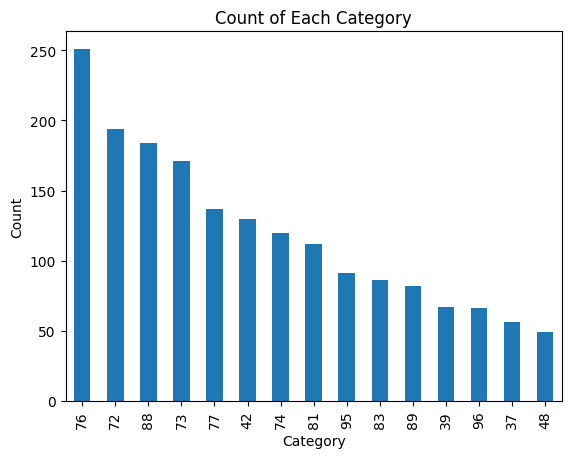

In [10]:
# Đoạn mã để đếm giá trị của cột "Category" và vẽ biểu đồ cột
df_15['Category'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category')
plt.show()

In [ ]:
# # Đoạn mã để đếm giá trị của cột "Category" và vẽ biểu đồ cột
# df['Category'].value_counts().plot(kind='bar')
# plt.xlabel('Category')
# plt.ylabel('Count')
# plt.title('Count of Each Category')
# plt.show()

In [11]:
print(f"Có {df_15['Category'].nunique()} loài hoa")
print("Giá trị lớn nhất của cột 'Category':", df['Category'].value_counts().max())
print("Giá trị nhỏ nhất của cột 'Category':", df['Category'].value_counts().min())

Có 15 loài hoa
Giá trị lớn nhất của cột 'Category': 258
Giá trị nhỏ nhất của cột 'Category': 40


In [ ]:
# print(f"Có {df['Category'].nunique()} loài hoa")
# print("Giá trị lớn nhất của cột 'Category':", df['Category'].value_counts().max())
# print("Giá trị nhỏ nhất của cột 'Category':", df['Category'].value_counts().min())

In [12]:
df_15['Category'].unique()   # giá trị từ 1 đến 101

array(['76', '72', '88', '73', '81', '77', '74', '42', '83', '89', '39',
       '37', '48', '95', '96'], dtype=object)

In [ ]:
# df['Category'].unique()   # giá trị từ 1 đến 101

In [13]:
PATH = os.getcwd() + "/"

Random Sample


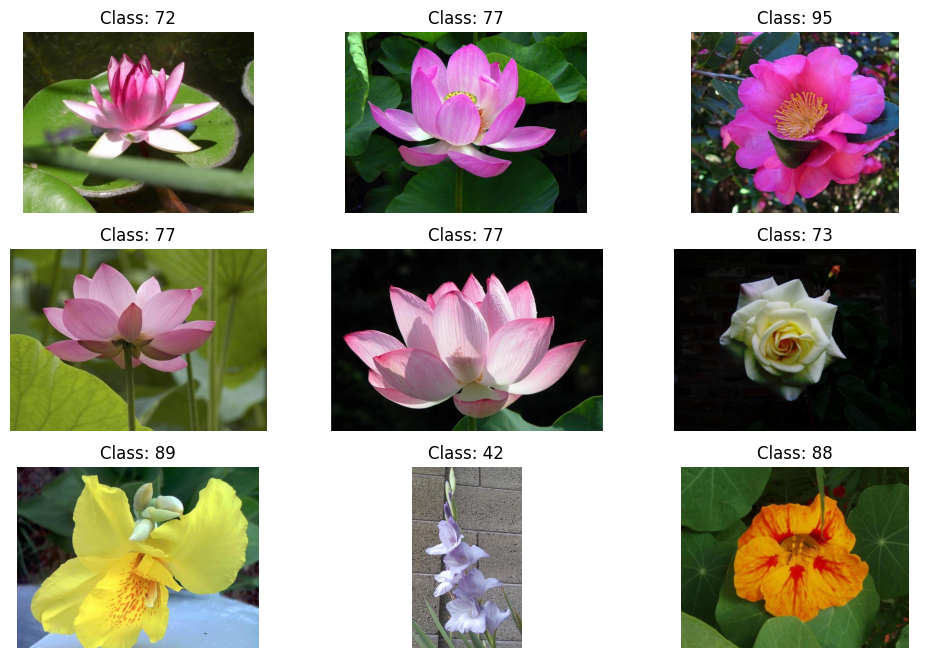

In [14]:
print('Random Sample')
plt.figure(figsize = (12, 8))
random_image = df_15.sample(n = 9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH + path)
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('Class: ' + str(random_image_cat[index]))
    plt.axis('off')

plt.show()

In [ ]:
# print('Random Sample')
# plt.figure(figsize = (12, 8))
# random_image = df.sample(n = 9)
# random_image_paths = random_image['Id'].values
# random_image_cat = random_image['Category'].values

# for index, path in enumerate(random_image_paths):
#     im = PIL.Image.open(PATH + path)
#     plt.subplot(3, 3, index + 1)
#     plt.imshow(im)
#     plt.title('Class: ' + str(random_image_cat[index]))
#     plt.axis('off')

# plt.show()

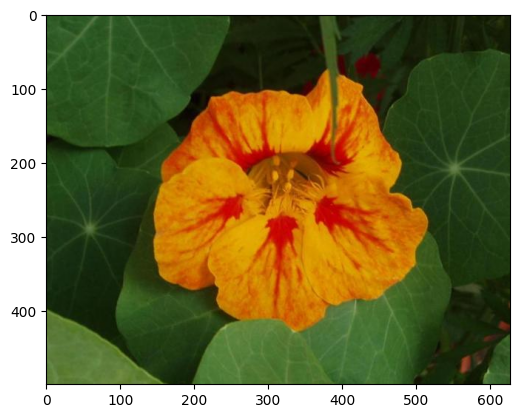

(627, 500)

In [15]:
image = PIL.Image.open(PATH + path)
imgplot = plt.imshow(image)
plt.show()
image.size

### Split Train Test

In [16]:
train_files, test_files, train_labels, test_labels = \
    train_test_split(
        df_15['Id'],
        df_15['Category'],
        test_size = 0.2,
        random_state = 42,
        stratify = df_15['Category']
)
train_files = pd.DataFrame(train_files)
test_files = pd.DataFrame(test_files)
train_files['Category'] = train_labels
test_files['Category'] = test_labels
train_files.shape, test_files.shape

((1436, 2), (360, 2))

In [ ]:
# train_files, test_files, train_labels, test_labels = \
#     train_test_split(
#         df['Id'],
#         df['Category'],
#         test_size = 0.2,
#         random_state = 42,
#         stratify = df['Category']
# )
# train_files = pd.DataFrame(train_files)
# test_files = pd.DataFrame(test_files)
# train_files['Category'] = train_labels
# test_files['Category'] = test_labels
# train_files.shape, test_files.shape

In [17]:
train_files.head(5)

,Id,Category
270,jpg/image_00271.jpg,72
6223,jpg/image_06224.jpg,48
263,jpg/image_00264.jpg,72
6210,jpg/image_06211.jpg,48
7678,jpg/image_07679.jpg,95


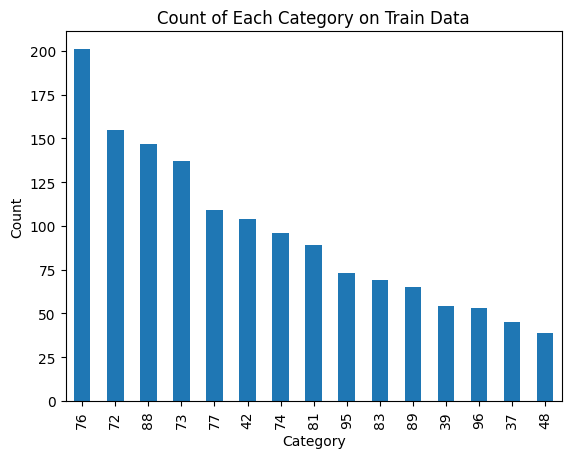

In [18]:
# Đoạn mã để đếm giá trị của cột "Category" và vẽ biểu đồ cột
train_files['Category'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category on Train Data')
plt.show()

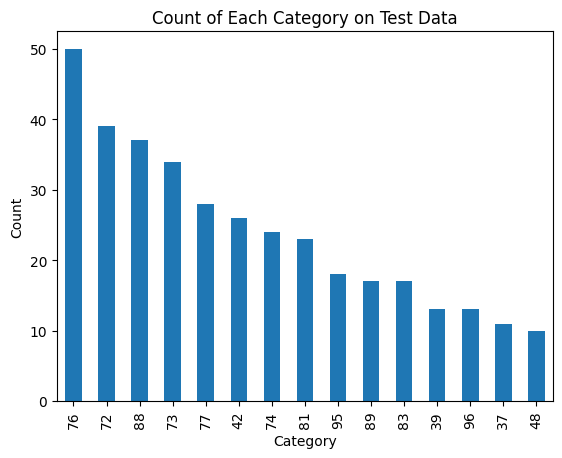

In [19]:
# Đoạn mã để đếm giá trị của cột "Category" và vẽ biểu đồ cột
test_files['Category'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category on Test Data')
plt.show()

### Data augmentation

In [20]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    rotation_range = 50,
    shear_range = 0.2,
    zoom_range = [0.75, 1.25],
    brightness_range = [0.5, 1.5],
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True
)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [21]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_files,
    directory = DATA_PATH,
    x_col = 'Id',
    y_col = 'Category',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True,
    seed = RANDOM_SEED
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_files,
    directory = DATA_PATH,
    x_col = 'Id',
    y_col = 'Category',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,
    seed = RANDOM_SEED
)

Found 1436 validated image filenames belonging to 15 classes.
Found 360 validated image filenames belonging to 15 classes.


In [22]:
train_generator.samples

1436

Ví dụ về hình ảnh từ train_generator


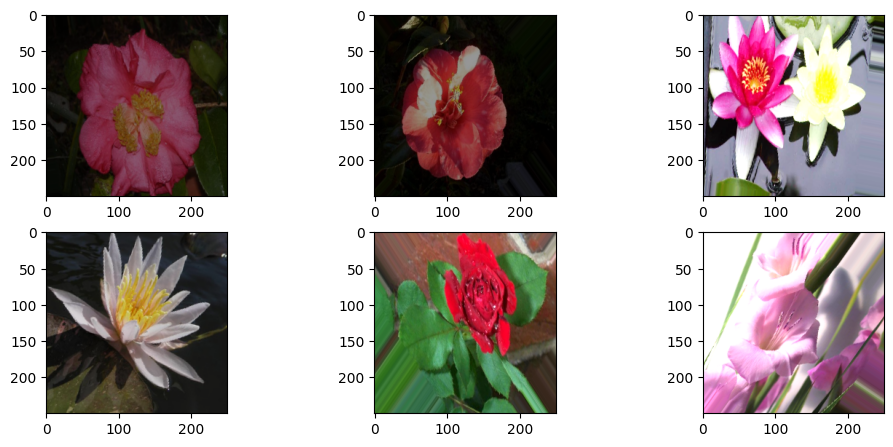

In [23]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x, y = train_generator.next()
print('Ví dụ về hình ảnh từ train_generator')
plt.figure(figsize = (12, 8))

for i in range(0, 6):
    image = x[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
#     plt.title('Class: ' + str(y[i]))
#     plt.axis('off')

plt.show()

Ví dụ về hình ảnh từ test_generator


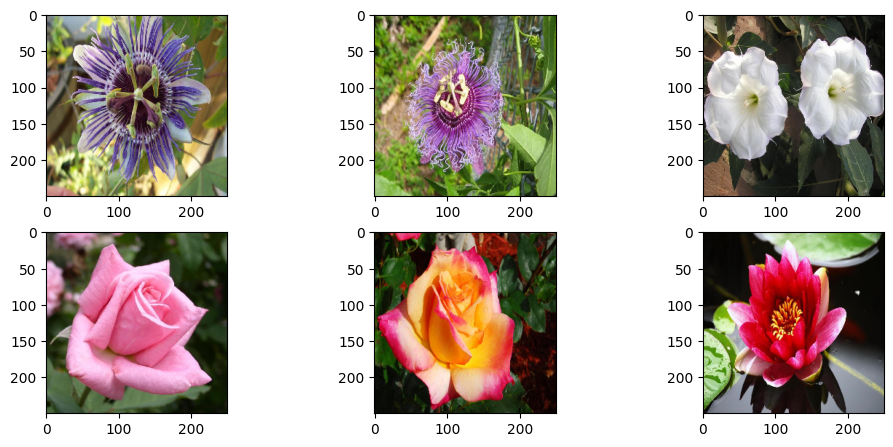

In [24]:
x, y = test_generator.next()
print('Ví dụ về hình ảnh từ test_generator')
plt.figure(figsize = (12, 8))

for i in range(0, 6):
    image = x[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
#     plt.title('Class: ' + str(y[i]))
#     plt.axis('off')

plt.show()

## My Model

### My model 1


In [ ]:
# My model 1
model = M.Sequential()
model.add(L.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(L.BatchNormalization())
model.add(L.Conv2D(32, (3, 3), activation='relu'))
model.add(L.BatchNormalization())
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Dropout(0.25))

model.add(L.Conv2D(64, (3, 3), activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Conv2D(64, (3, 3), activation='relu'))
model.add(L.BatchNormalization())
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Dropout(0.25))

model.add(L.Conv2D(128, (3, 3), activation='relu'))
model.add(L.BatchNormalization())
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Dropout(0.25))

model.add(L.Flatten())
model.add(L.Dense(512, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.5))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

### My model 2

In [ ]:
model = M.Sequential([
    L.Conv2D(16, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape),
    L.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'),
    L.Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu'),
    L.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'),
    L.Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu'),
    L.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'),
    L.Conv2D(128, (5, 5), strides=(1, 1), padding='same', activation='relu'),
    L.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'),
    L.Flatten(),
    L.Dense(1024, activation='tanh'),
    L.Dropout(0.2),
    L.Dense(256, activation='tanh'),
    L.Dropout(0.2),
    L.Dense(CLASS_NUM, activation='softmax')
])

### My model 3

In [ ]:
model = M.Sequential([
    L.Conv2D(16, (5, 5), strides=(1, 1), padding='same', input_shape=input_shape),
    L.BatchNormalization(),
    L.Activation('relu'),
    L.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'),

    L.Conv2D(32, (5, 5), strides=(1, 1), padding='same'),
    L.BatchNormalization(),
    L.Activation('relu'),
    L.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'),

    L.Conv2D(64, (5, 5), strides=(1, 1), padding='same'),
    L.BatchNormalization(),
    L.Activation('relu'),
    L.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'),

    L.Conv2D(128, (5, 5), strides=(1, 1), padding='same'),
    L.BatchNormalization(),
    L.Activation('relu'),
    L.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'),

    L.Flatten(),
    L.Dense(1024, activation='relu'),
    L.Dropout(0.2),
    L.Dense(256, activation='relu'),
    L.Dropout(0.2),
    L.Dense(CLASS_NUM, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 248, 248, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 248, 248, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 246, 246, 32)      9248      
                                                                 
 batch_normalization_5 (Bat  (None, 246, 246, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 123, 123, 32)      0         
 ng2D)                                                           
                                                      

### Huấn luyện

In [ ]:
# check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizers.Adam(learning_rate = LR_step1),
    metrics = ['accuracy']
)

In [ ]:
checkpoint = ModelCheckpoint(
    'best_mymodel_2_.hdf5',
    monitor = ['val_accuracy'],
    verbose = 1,
    mode = 'max'
)
earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    restore_best_weights = True
)
callbacks_list = [checkpoint, earlystop]

In [ ]:
train_generator.samples

1436

In [ ]:
# fit include generator
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 50,
    callbacks = callbacks_list
)

Epoch 1/50
179/179 [==============================] - ETA: 0s - loss: 0.8920 - accuracy: 0.7241
Epoch 1: saving model to best_mymodel_3.hdf5
179/179 [==============================] - 43s 238ms/step - loss: 0.8920 - accuracy: 0.7241 - val_loss: 0.6979 - val_accuracy: 0.7472
Epoch 2/50
179/179 [==============================] - ETA: 0s - loss: 0.8170 - accuracy: 0.7311
Epoch 2: saving model to best_mymodel_3.hdf5
179/179 [==============================] - 41s 227ms/step - loss: 0.8170 - accuracy: 0.7311 - val_loss: 0.7110 - val_accuracy: 0.7667
Epoch 3/50
179/179 [==============================] - ETA: 0s - loss: 0.8419 - accuracy: 0.7291
Epoch 3: saving model to best_mymodel_3.hdf5
179/179 [==============================] - 43s 239ms/step - loss: 0.8419 - accuracy: 0.7291 - val_loss: 0.8719 - val_accuracy: 0.7639
Epoch 4/50
138/179 [======================>.......] - ETA: 7s - loss: 0.8526 - accuracy: 0.7264

In [ ]:
# model.save('./SaveModel/my_model_2_s128_step1.hdf5')
# model.load_weights('best_model_test_2.hdf5')
model.load_weights('./SaveModel/my_model_2_s128_step1.hdf5')

ValueError: Cannot assign value to variable ' dense/kernel:0': Shape mismatch.The variable shape (28800, 1024), and the assigned value shape (8192, 1024) are incompatible.

In [ ]:
# scores = model.evaluate_generator(test_generator, verbose = 1)
scores = model.evaluate(test_generator, verbose=1)
print('Accuracy: %.2f%%' % (scores[1] * 100))

45/45 [==============================] - 3s 61ms/step - loss: 0.7257 - accuracy: 0.7833
Accuracy: 78.33%


In [ ]:
def plot_history(history):
    plt.figure(figsize = (10, 5))
#     plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b', label = 'Training acc')
    plt.plot(epochs, val_acc, 'g', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
#     plt.figure()
    plt.figure(figsize = (10, 5))
#     plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label = 'Training loss')
    plt.plot(epochs, val_loss, 'g', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

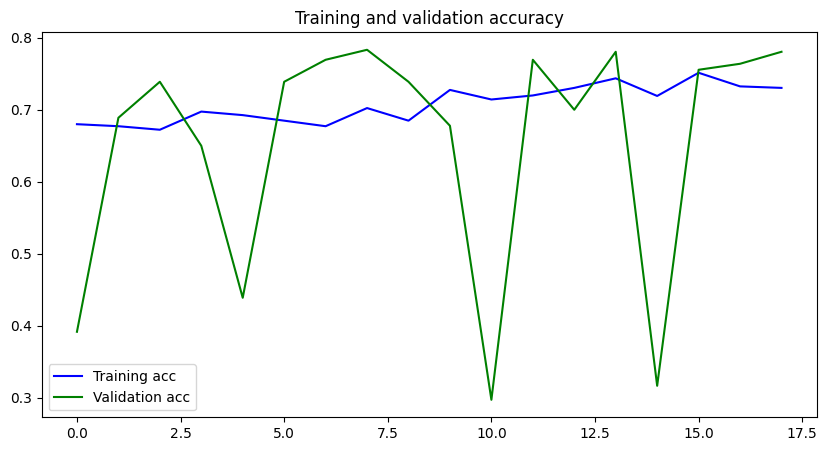

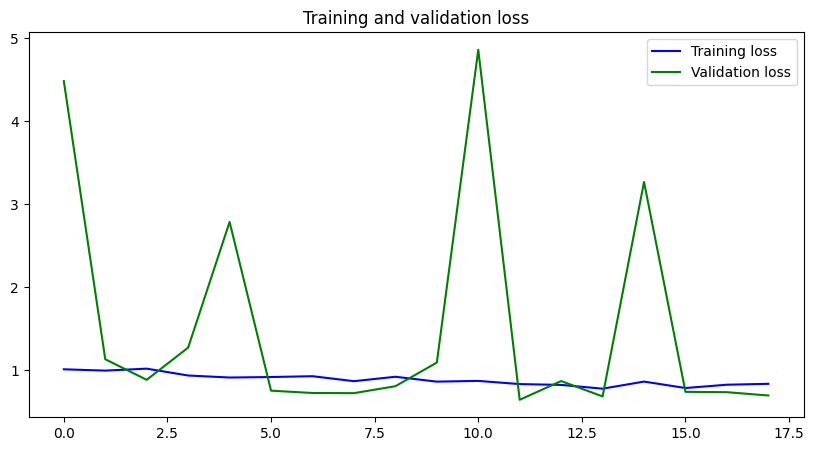

In [ ]:
plot_history(history)

## Model Lenet5

### Lenet5

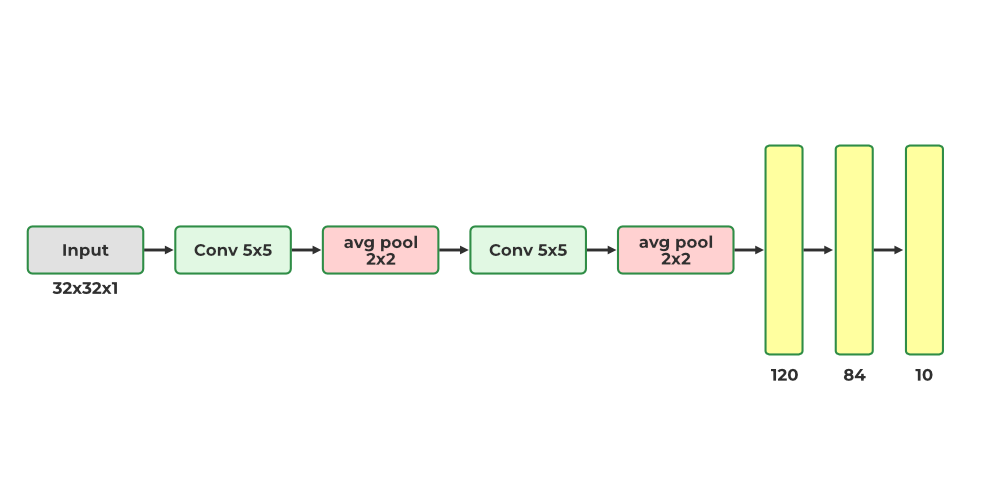

In [ ]:
lenet5_model = M.Sequential()
lenet5_model.add(L.Conv2D(16, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape))
# L.Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu')
lenet5_model.add(L.AveragePooling2D(2))
lenet5_model.add(L.Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu'))
lenet5_model.add(L.AveragePooling2D(2))
lenet5_model.add(L.Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu'))
lenet5_model.add(L.AveragePooling2D(2))
lenet5_model.add(L.Conv2D(128, (5, 5), strides=(1, 1), padding='same', activation='relu'))
lenet5_model.add(L.AveragePooling2D(2))
lenet5_model.add(L.Flatten())
lenet5_model.add(L.Dense(1024, activation='relu'))
lenet5_model.add(L.Dense(768, activation='relu'))
# lenet5_model.add(L.Dense(10, activation='softmax'))

In [ ]:
# old
# lenet5_model = M.Sequential()
# lenet5_model.add(L.Conv2D(16, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape))
# L.Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu')
# lenet5_model.add(L.AveragePooling2D(2))
# lenet5_model.add(L.Conv2D(16, 5, activation='tanh'))
# lenet5_model.add(L.AveragePooling2D(2))
# lenet5_model.add(L.Activation('sigmoid'))
# lenet5_model.add(L.Conv2D(6, 5, activation='tanh'))
# lenet5_model.add(L.Flatten())
# lenet5_model.add(L.Dense(2048, activation='tanh'))
# # lenet5_model.add(L.Dense(10, activation='softmax'))

In [ ]:
# Print model summary
lenet5_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 250, 250, 16)      1216      
                                                                 
 average_pooling2d_5 (Avera  (None, 125, 125, 16)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_20 (Conv2D)          (None, 125, 125, 32)      12832     
                                                                 
 average_pooling2d_6 (Avera  (None, 62, 62, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_21 (Conv2D)          (None, 62, 62, 64)        51264     
                                                                 
 average_pooling2d_7 (Avera  (None, 31, 31, 64)       

In [ ]:
model = M.Sequential()
model.add(lenet5_model)
# model.add(L.GlobalAveragePooling2D())
model.add(L.Dense(CLASS_NUM, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 768)               30549664  
                                                                 
 dense_14 (Dense)            (None, 15)                11535     
                                                                 
Total params: 30561199 (116.58 MB)
Trainable params: 30561199 (116.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
print(len(model.layers))
print(len(model.trainable_variables))

2
14


In [ ]:
# check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.src.engine.sequential.Sequential object at 0x7aab925af2e0> True
<keras.src.layers.core.dense.Dense object at 0x7aab8ec446d0> True


In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizers.Adam(learning_rate = LR_step1),
    metrics = ['accuracy']
)

earlystop:
- monitor - giám sát trên thang đo val_acc
- patience - số lượng epochs không cải thiện độ chính xác sẽ dừng
- restore_best_weights - quay lại trọng số cho độ chính xác tốt nhất

In [ ]:
checkpoint = ModelCheckpoint(
    'best_model_test.hdf5',
    monitor = ['val_accuracy'],
    verbose = 1,
    mode = 'max'
)
earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    restore_best_weights = True
)
callbacks_list = [checkpoint, earlystop]

In [ ]:
# scores = model.evaluate(test_generator, verbose=1)
# print('Accuracy: %.2f%%' % (scores[1] * 100))

### Huấn luyện

đã huấn luyện được 12 epoch

In [ ]:
# fit include generator
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 50,
    callbacks = callbacks_list
)

Epoch 1/50
179/179 [==============================] - ETA: 0s - loss: 2.4272 - accuracy: 0.2080
Epoch 1: saving model to best_model_test.hdf5
179/179 [==============================] - 42s 220ms/step - loss: 2.4272 - accuracy: 0.2080 - val_loss: 2.1217 - val_accuracy: 0.2889
Epoch 2/50
179/179 [==============================] - ETA: 0s - loss: 2.1194 - accuracy: 0.2864
Epoch 2: saving model to best_model_test.hdf5
179/179 [==============================] - 43s 242ms/step - loss: 2.1194 - accuracy: 0.2864 - val_loss: 1.9666 - val_accuracy: 0.3000
Epoch 3/50
179/179 [==============================] - ETA: 0s - loss: 2.0225 - accuracy: 0.3109
Epoch 3: saving model to best_model_test.hdf5
179/179 [==============================] - 46s 257ms/step - loss: 2.0225 - accuracy: 0.3109 - val_loss: 2.0714 - val_accuracy: 0.3278
Epoch 4/50
179/179 [==============================] - ETA: 0s - loss: 1.9505 - accuracy: 0.3179
Epoch 4: saving model to best_model_test.hdf5
179/179 [=====================

In [ ]:
model.save('./SaveModel/model_lenet5_step1.hdf5')
# model.load_weights('best_model_test.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# scores = model.evaluate_generator(test_generator, verbose = 1)
scores = model.evaluate(test_generator, verbose=1)
print('Accuracy: %.2f%%' % (scores[1] * 100))

45/45 [==============================] - 3s 63ms/step - loss: 3.2911 - accuracy: 0.1389
Accuracy: 13.89%


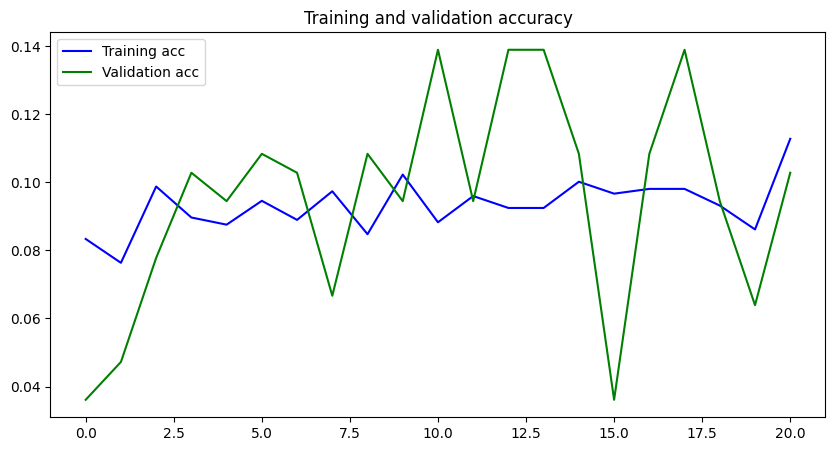

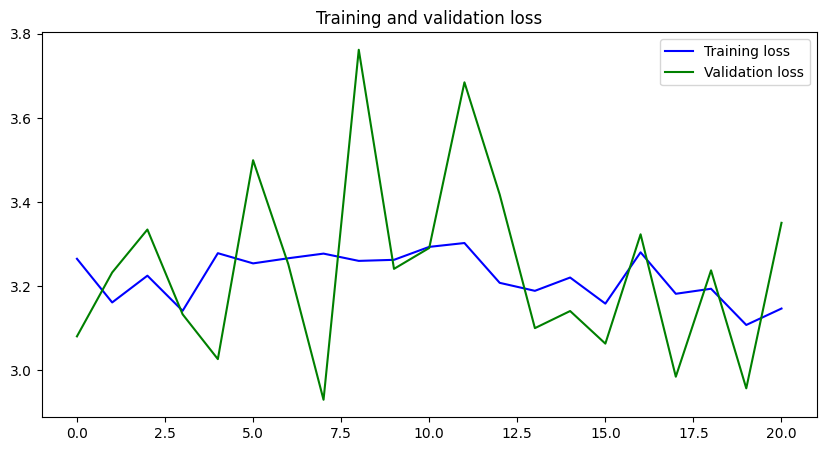

In [ ]:
plot_history(history)

## Model AlexNet

### AlexNet

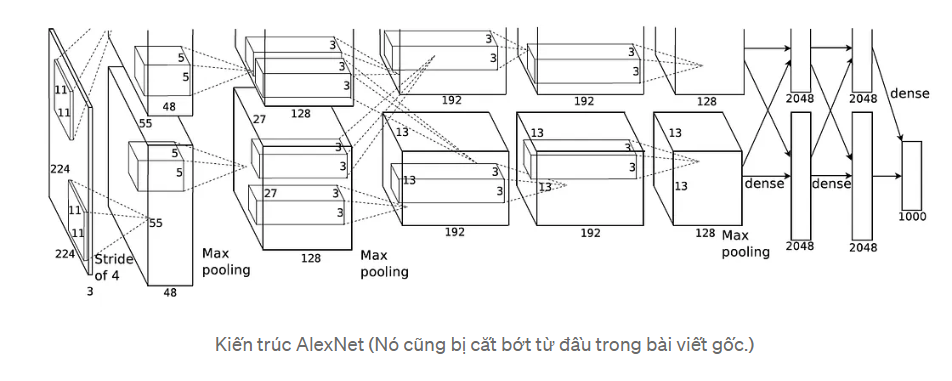

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout


model=Sequential()

#1 conv layer
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(224,224,3)))

#1 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#2 conv layer
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

#2 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#3 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#4 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#5 conv layer
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#3 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())


model.add(Flatten())

#1 dense layer
model.add(Dense(4096,input_shape=(224,224,3),activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#2 dense layer
model.add(Dense(4096,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#3 dense layer
model.add(Dense(1000,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#output layer
model.add(Dense(CLASS_NUM,activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 26, 26, 96)        384       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 256)       0         
 g2D)                                                            
                                                        

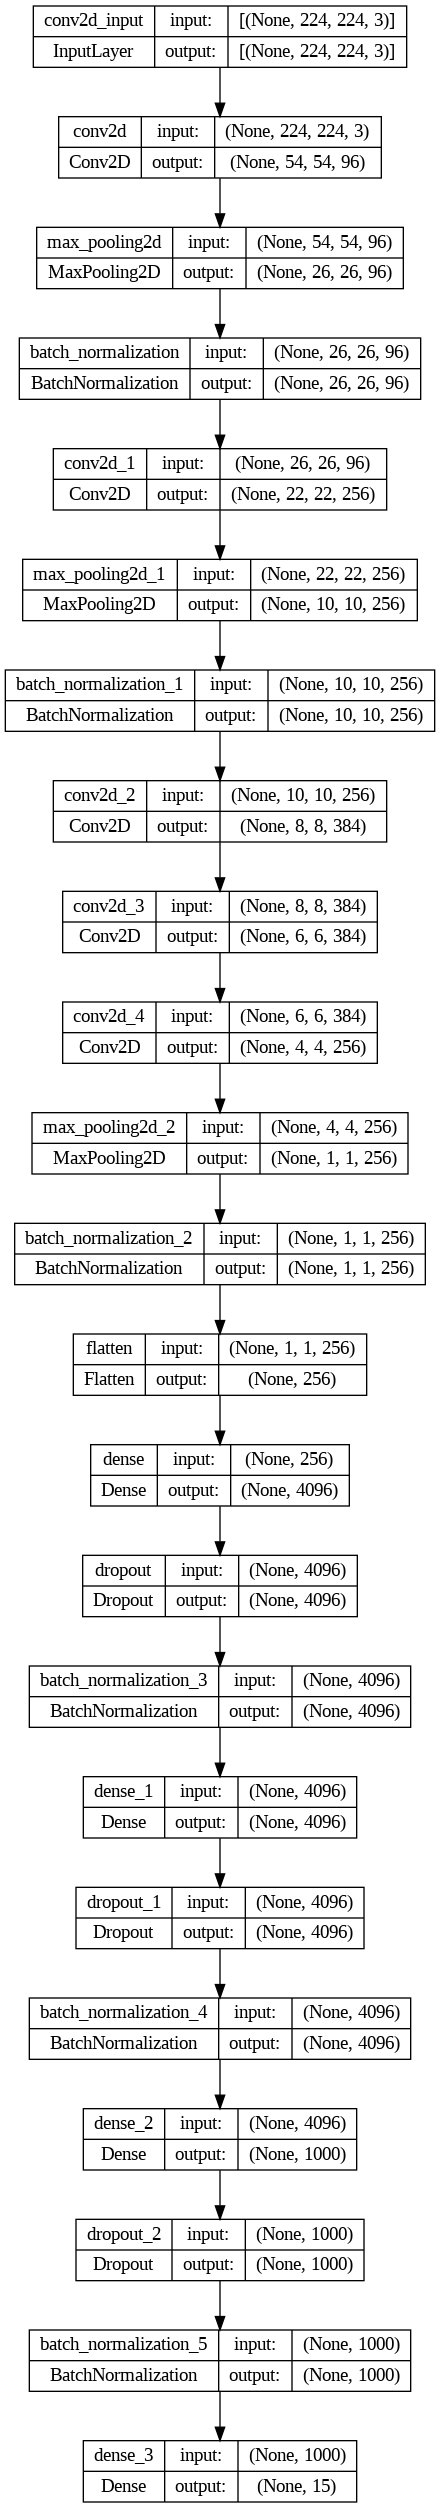

In [ ]:
# Vẽ mô hình
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# L.Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu')
# # old
# model_alexnet = M.Sequential()
# model_alexnet.add(L.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=input_shape))
# model_alexnet.add(L.Conv2D(96, (11, 11), strides=(4, 4), padding='same', activation='relu'))
# model_alexnet.add(L.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'))
# model_alexnet.add(L.Conv2D(256, (5, 5), strides=(2, 2), padding='same', activation='relu'))
# model_alexnet.add(L.MaxPooling2D((2, 2), strides=(1, 1), padding='same'))
# model_alexnet.add(L.Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu'))
# model_alexnet.add(L.Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu'))
# model_alexnet.add(L.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))
# model_alexnet.add(L.MaxPooling2D((2, 2), strides=(2, 2), padding='valid'))
# model_alexnet.add(L.Flatten())
# model_alexnet.add(L.Dense(2048, activation='relu'))
# model_alexnet.add(L.Dense(2048, activation='relu'))
# # model_alexnet.add(L.Dense(10, activation='softmax'))
# model_alexnet.summary()

In [ ]:
# # old false
# model_alexnet = M.Sequential()
# model_alexnet.add(L.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=input_shape))
# model_alexnet.add(L.Conv2D(96, 11, strides=4, padding='same'))
# model_alexnet.add(L.Lambda(tf.nn.local_response_normalization))
# model_alexnet.add(L.Activation('relu'))
# model_alexnet.add(L.MaxPooling2D(3, strides=2))
# model_alexnet.add(L.Conv2D(256, 5, strides=4, padding='same'))
# model_alexnet.add(L.Lambda(tf.nn.local_response_normalization))
# model_alexnet.add(L.Activation('relu'))
# model_alexnet.add(L.MaxPooling2D(3, strides=2))
# model_alexnet.add(L.Conv2D(384, 3, strides=2, padding='same'))
# model_alexnet.add(L.Activation('relu'))
# model_alexnet.add(L.Conv2D(384, 3, strides=2, padding='same'))
# model_alexnet.add(L.Activation('relu'))
# model_alexnet.add(L.Conv2D(256, 3, strides=2, padding='same'))
# model_alexnet.add(L.Activation('relu'))
# model_alexnet.add(L.Flatten())
# model_alexnet.add(L.Dense(4096, activation='relu'))
# model_alexnet.add(L.Dropout(0.5))
# model_alexnet.add(L.Dense(4096, activation='relu'))
# # model_alexnet.add(L.Dense(10, activation='softmax'))
# model_alexnet.summary()

In [ ]:
model = M.Sequential()
model.add(model_alexnet)
# model.add(L.GlobalAveragePooling2D())
model.add(L.Dense(CLASS_NUM, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 2048)              33635712  
                                                                 
 dense_25 (Dense)            (None, 15)                30735     
                                                                 
Total params: 33666447 (128.43 MB)
Trainable params: 33666447 (128.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
print(len(model.layers))
print(len(model.trainable_variables))

2
16


In [ ]:
# check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.src.engine.sequential.Sequential object at 0x7f6e503a3130> True
<keras.src.layers.core.dense.Dense object at 0x7f6e504d1270> True


In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizers.Adam(learning_rate = LR_step1),
    metrics = ['accuracy']
)

### Huấn luyện

In [ ]:
checkpoint = ModelCheckpoint(
    'best_model_test_2.hdf5',
    monitor = ['val_accuracy'],
    verbose = 1,
    mode = 'max'
)
earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    restore_best_weights = True
)
callbacks_list = [checkpoint, earlystop]

In [ ]:
# fit include generator
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 50,
    callbacks = callbacks_list
)

Epoch 1/50
179/179 [==============================] - ETA: 0s - loss: 2.6469 - accuracy: 0.1324
Epoch 1: saving model to best_model_test_2.hdf5
179/179 [==============================] - 43s 229ms/step - loss: 2.6469 - accuracy: 0.1324 - val_loss: 2.6120 - val_accuracy: 0.1389
Epoch 2/50
179/179 [==============================] - ETA: 0s - loss: 2.6206 - accuracy: 0.1401
Epoch 2: saving model to best_model_test_2.hdf5
179/179 [==============================] - 40s 225ms/step - loss: 2.6206 - accuracy: 0.1401 - val_loss: 2.6033 - val_accuracy: 0.1389
Epoch 3/50
179/179 [==============================] - ETA: 0s - loss: 2.6123 - accuracy: 0.1359
Epoch 3: saving model to best_model_test_2.hdf5
179/179 [==============================] - 39s 219ms/step - loss: 2.6123 - accuracy: 0.1359 - val_loss: 2.6068 - val_accuracy: 0.1389
Epoch 4/50
179/179 [==============================] - ETA: 0s - loss: 2.6125 - accuracy: 0.1401
Epoch 4: saving model to best_model_test_2.hdf5
179/179 [=============

In [ ]:
model.save('./SaveModel/model_alexnet_step1.hdf5')
# model.load_weights('best_model_test_2.hdf5')

## Cur

In [ ]:
# scores = model.evaluate_generator(test_generator, verbose = 1)
scores = model.evaluate(test_generator, verbose=1)
print('Accuracy: %.2f%%' % (scores[1] * 100))

14/14 [==============================] - 1s 57ms/step - loss: 2.5928 - accuracy: 0.1696
Accuracy: 16.96%


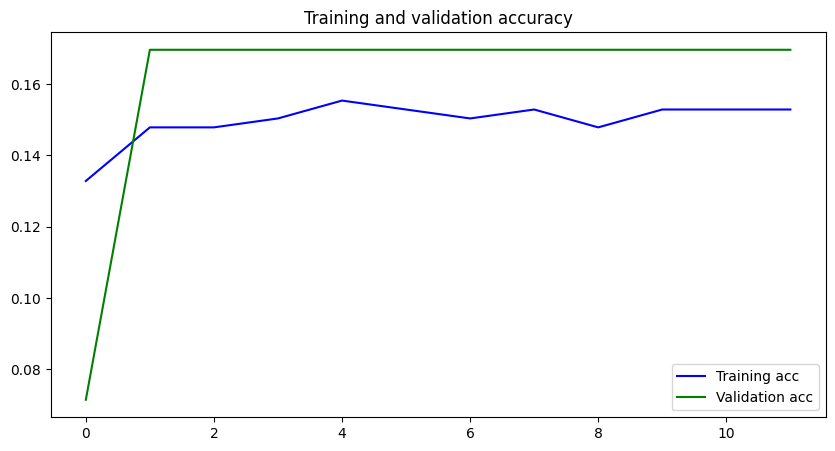

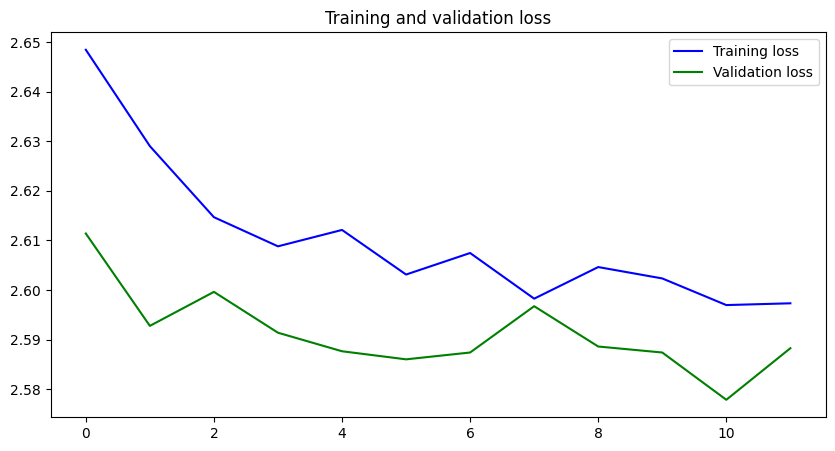

In [ ]:
plot_history(history)

## Model Google Net

### Google Net

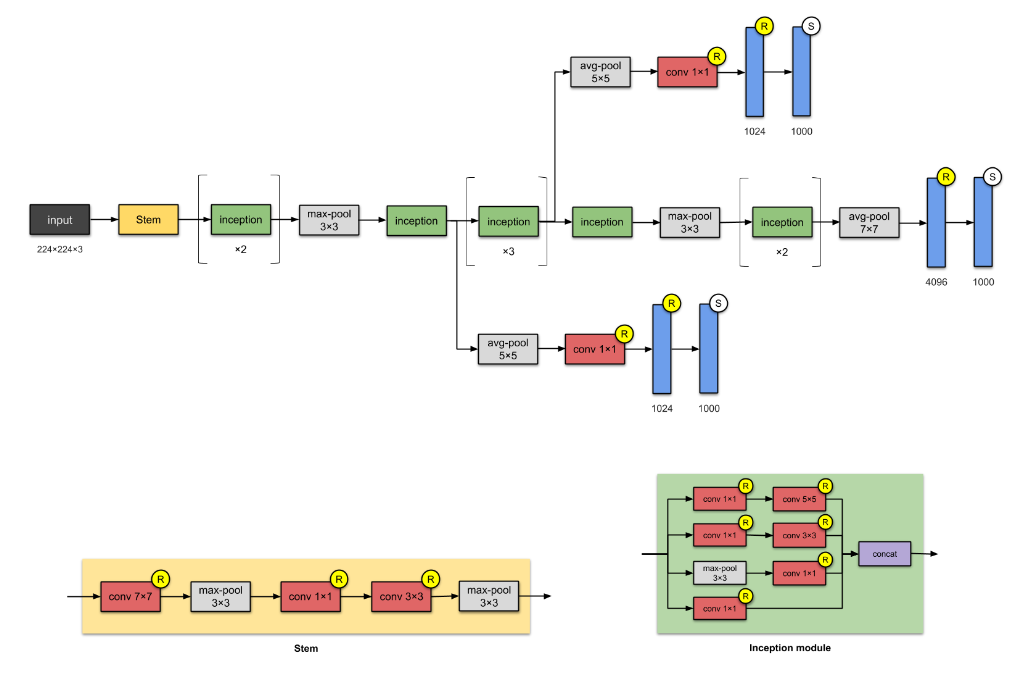

In [ ]:
# Imports
# from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Concatenate, \
#     AvgPool2D, Dropout, Flatten, Dense
from tensorflow.keras import Model

# Stem block
def stem_block(input) :
    sb = L.Conv2D(filters=64, kernel_size=7, strides=2, padding='same',
                activation='relu')(input)
    sb = L.MaxPool2D(pool_size=3, strides=2, padding='same')(sb)
    sb = L.Conv2D(filters=64, kernel_size=1, activation='relu')(sb)
    sb = L.Conv2D(filters=192, kernel_size=3, padding='same',
                activation='relu')(sb)
    sb = L.MaxPool2D(pool_size=3, strides=2)(sb)
    return sb

# Inception block
# You can build a simple model to visualize the result of this function
# to test the Inception block.
def inception_block(x, filters):

    c1 = L.Conv2D(filters=filters[0], kernel_size=1, activation='relu')(x)

    c2 = L.Conv2D(filters=filters[1], kernel_size=1, activation='relu')(x)
    c2 = L.Conv2D(filters=filters[2], kernel_size=3, padding='same',
                activation='relu')(c2)

    c3 = L.Conv2D(filters=filters[3], kernel_size=1, activation='relu')(x)
    c3 = L.Conv2D(filters=filters[4], kernel_size=5, padding='same',
                activation='relu')(c3)

    mp = L.MaxPool2D(pool_size=3, strides=1, padding='same')(x)
    c4 = L.Conv2D(filters=filters[5], kernel_size=1, activation='relu')(mp)

    output = L.Concatenate()([c1, c2, c3, c4])
    return output

# Input
input = L.Input(shape=input_shape)  #(224, 224, 3)

# Blocks
my_model = stem_block(input)

my_model = inception_block(my_model, filters=[64, 96, 128, 16, 32, 32])
my_model = inception_block(my_model, filters=[128, 128, 192, 32, 96, 64])
my_model = L.MaxPool2D(pool_size=3, strides=2, padding='same')(my_model)

my_model = inception_block(my_model, filters=[192, 96, 208, 16, 48, 64])
my_model = inception_block(my_model, filters=[160, 112, 224, 24, 64, 64])
my_model = inception_block(my_model, filters=[128, 128, 256, 24, 64, 64])
my_model = inception_block(my_model, filters=[112, 144, 288, 32, 64, 64])
my_model = inception_block(my_model, filters=[256, 160, 320, 32, 128, 128])
my_model = L.MaxPool2D(pool_size=3, strides=2, padding='same')(my_model)

my_model = inception_block(my_model, filters=[256, 160, 320, 32, 128, 128])
my_model = inception_block(my_model, filters=[384, 192, 384, 48, 128, 128])
my_model = L.AvgPool2D(pool_size=7, strides=1)(my_model)
my_model = L.Dropout(rate=0.4)(my_model)

# Dense layers
my_model = L.Flatten()(my_model)
my_model = L.Dense(units=4096, activation='relu')(my_model)

# Output layer
output = L.Dense(units=CLASS_NUM, activation='softmax')(my_model)

# Model
GoogLeNet_model = Model(inputs=input, outputs=output)

In [ ]:
print(GoogLeNet_model.summary())

In [ ]:
plot_model(GoogLeNet_model)

### Huấn luyện

In [ ]:
print(len(GoogLeNet_model.layers))
print(len(GoogLeNet_model.trainable_variables))

In [ ]:
# check the trainable status of the individual layers
for layer in GoogLeNet_model.layers:
    print(layer, layer.trainable)

In [ ]:
GoogLeNet_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizers.Adam(learning_rate = LR_step1),
    metrics = ['accuracy']
)

In [ ]:
checkpoint = ModelCheckpoint(
    'best_model_test_2.hdf5',
    monitor = ['val_accuracy'],
    verbose = 1,
    mode = 'max'
)
earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 10,
    restore_best_weights = True
)
callbacks_list = [checkpoint, earlystop]

In [ ]:
# fit include generator
history = GoogLeNet_model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 50,
    callbacks = callbacks_list
)

Epoch 1/50
179/179 [==============================] - ETA: 0s - loss: 2.6378 - accuracy: 0.1324
Epoch 1: saving model to best_model_test_2.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


179/179 [==============================] - 72s 277ms/step - loss: 2.6378 - accuracy: 0.1324 - val_loss: 2.6294 - val_accuracy: 0.1389
Epoch 2/50
179/179 [==============================] - ETA: 0s - loss: 2.6157 - accuracy: 0.1373
Epoch 2: saving model to best_model_test_2.hdf5
179/179 [==============================] - 46s 258ms/step - loss: 2.6157 - accuracy: 0.1373 - val_loss: 2.6143 - val_accuracy: 0.1389
Epoch 3/50
179/179 [==============================] - ETA: 0s - loss: 2.6130 - accuracy: 0.1345
Epoch 3: saving model to best_model_test_2.hdf5
179/179 [==============================] - 46s 260ms/step - loss: 2.6130 - accuracy: 0.1345 - val_loss: 2.6027 - val_accuracy: 0.1389
Epoch 4/50
179/179 [==============================] - ETA: 0s - loss: 2.6101 - accuracy: 0.1401
Epoch 4: saving model to best_model_test_2.hdf5
179/179 [==============================] - 47s 265ms/step - loss: 2.6101 - accuracy: 0.1401 - val_loss: 2.6015 - val_accuracy: 0.1389
Epoch 5/50
179/179 [============

KeyboardInterrupt: 

## this

In [ ]:
GoogLeNet_model.save('./SaveModel/model_ggnet_step1.hdf5')
# model.load_weights('best_model_test_2.hdf5')

In [ ]:
# scores = model.evaluate_generator(test_generator, verbose = 1)
scores = model.evaluate(test_generator, verbose=1)
print('Accuracy: %.2f%%' % (scores[1] * 100))

In [ ]:
plot_history(history)

## Model Transfer Learning EfficientNetB6

In [25]:
input_shape

(250, 250, 3)

In [58]:
base_model = efn.EfficientNetB6(
    weights = 'imagenet',
    include_top = False,
    input_shape = input_shape
)

In [ ]:
# base_model.summary()

In [32]:
base_model.trainable = False

In [59]:
model = M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D())
model.add(L.Dense(CLASS_NUM, activation = 'softmax'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b6 (Functiona  (None, 8, 8, 2304)        40960136  
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 2304)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 15)                34575     
                                                                 
Total params: 40994711 (156.38 MB)
Trainable params: 34575 (135.06 KB)
Non-trainable params: 40960136 (156.25 MB)
_________________________________________________________________


In [60]:
print(len(model.layers))

3


In [61]:
len(model.trainable_variables)

584

In [62]:
# check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.src.engine.functional.Functional object at 0x7cc1d8262020> True
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7cc5defbf580> True
<keras.src.layers.core.dense.Dense object at 0x7cc5dfda7130> True


### Step 1: Freeze Base Layer + Training new Head Classifier

In [63]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizers.Adam(learning_rate = LR_step1),
    metrics = ['accuracy']
)

In [74]:
checkpoint = ModelCheckpoint(
    './ManhModel/fine_tuning_best_model_step1.h5',
    monitor = ['val_accuracy'],
    verbose = 1,
    mode = 'max'
)
earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
)
callbacks_list = [checkpoint, earlystop]

Đánh giá trước khi huấn luyện

In [75]:
# scores = model.evaluate_generator(test_generator, verbose = 1)
scores = model.evaluate(test_generator, verbose=1)
print('Accuracy: %.2f%%' % (scores[1] * 100))

45/45 [==============================] - 4s 92ms/step - loss: 3.4942 - accuracy: 0.6667
Accuracy: 66.67%


In [76]:
print(train_generator.samples)

1436


In [77]:
# fit include generator
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 5,
    callbacks = callbacks_list
)

Epoch 1/5
179/179 [==============================] - ETA: 0s - loss: 0.3246 - accuracy: 0.9020
Epoch 1: saving model to ./ManhModel/fine_tuning_best_model_step1.h5
179/179 [==============================] - 89s 497ms/step - loss: 0.3246 - accuracy: 0.9020 - val_loss: 0.8019 - val_accuracy: 0.8528
Epoch 2/5
179/179 [==============================] - ETA: 0s - loss: 0.3293 - accuracy: 0.9041
Epoch 2: saving model to ./ManhModel/fine_tuning_best_model_step1.h5
179/179 [==============================] - 95s 532ms/step - loss: 0.3293 - accuracy: 0.9041 - val_loss: 0.6219 - val_accuracy: 0.8556
Epoch 3/5
179/179 [==============================] - ETA: 0s - loss: 0.2961 - accuracy: 0.9062
Epoch 3: saving model to ./ManhModel/fine_tuning_best_model_step1.h5
179/179 [==============================] - 105s 585ms/step - loss: 0.2961 - accuracy: 0.9062 - val_loss: 0.2052 - val_accuracy: 0.9333
Epoch 4/5
179/179 [==============================] - ETA: 0s - loss: 0.2257 - accuracy: 0.9342
Epoch 4: s

In [79]:
model.save('./ManhModel/EfficientNet_model_step1.h5')
# model.load_weights('best_model.hdf5')

Đánh giá sau khi huấn luyện

In [78]:
# scores = model.evaluate_generator(test_generator, verbose = 1)
scores = model.evaluate(test_generator, verbose=1)
print('Accuracy: %.2f%%' % (scores[1] * 100))

45/45 [==============================] - 4s 93ms/step - loss: 0.2516 - accuracy: 0.9417
Accuracy: 94.17%


Visualizer training history

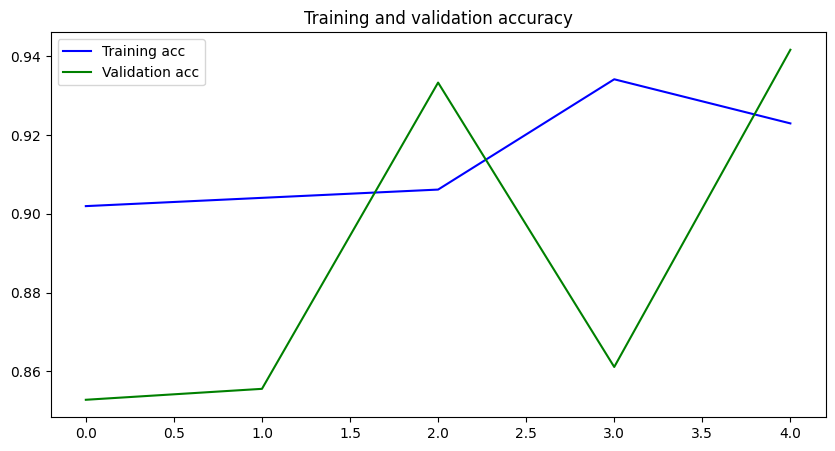

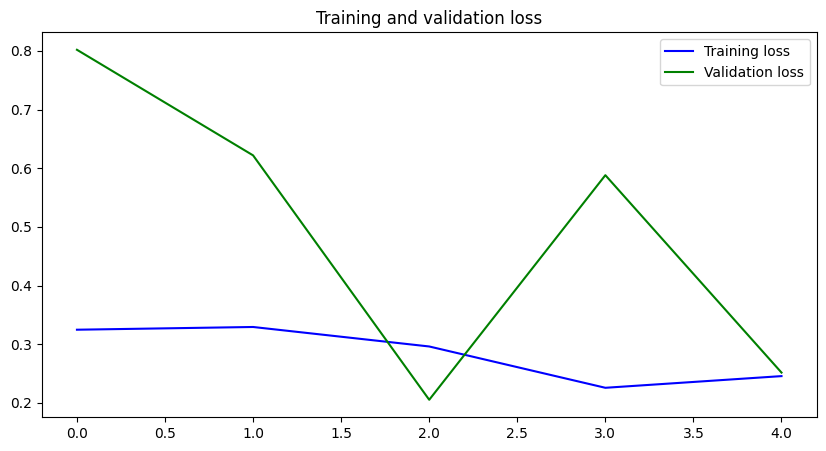

In [80]:
def plot_history(history):
    plt.figure(figsize = (10, 5))
#     plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b', label = 'Training acc')
    plt.plot(epochs, val_acc, 'g', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
#     plt.figure()
    plt.figure(figsize = (10, 5))
#     plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label = 'Training loss')
    plt.plot(epochs, val_loss, 'g', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


plot_history(history)

### Step 2: Freeze a half layers of base_model and fine-turning

In [81]:
# let's take a look to see how many layers are in the base model
print('Number of layers in the base model:', len(base_model.layers))

Number of layers in the base model: 659


In [82]:
base_model.trainable = True

# fine-tune from this layer onwards
fine_tune_at = len(base_model.layers) // 2

# freeze all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [83]:
len(base_model.trainable_variables)

291

In [84]:
# check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.src.engine.functional.Functional object at 0x7cc1d8262020> True
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7cc5defbf580> True
<keras.src.layers.core.dense.Dense object at 0x7cc5dfda7130> True


In [85]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizers.Adam(learning_rate = LR_step2),
    metrics = ['accuracy']
)

In [86]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b6 (Functiona  (None, 8, 8, 2304)        40960136  
 l)                                                              
                                                                 
 global_average_pooling2d_1  (None, 2304)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 15)                34575     
                                                                 
Total params: 40994711 (156.38 MB)
Trainable params: 37731045 (143.93 MB)
Non-trainable params: 3263666 (12.45 MB)
_________________________________________________________________


In [87]:
scores = model.evaluate(test_generator, verbose=1)
print('Accuracy: %.2f%%' % (scores[1] * 100))

45/45 [==============================] - 10s 102ms/step - loss: 0.2516 - accuracy: 0.9417
Accuracy: 94.17%


In [88]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 10,
    callbacks = callbacks_list
)

Epoch 1/10
179/179 [==============================] - ETA: 0s - loss: 0.1135 - accuracy: 0.9692
Epoch 1: saving model to ./ManhModel/fine_tuning_best_model_step1.h5
179/179 [==============================] - 124s 377ms/step - loss: 0.1135 - accuracy: 0.9692 - val_loss: 0.1180 - val_accuracy: 0.9667
Epoch 2/10
179/179 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 0.9734
Epoch 2: saving model to ./ManhModel/fine_tuning_best_model_step1.h5
179/179 [==============================] - 74s 413ms/step - loss: 0.0915 - accuracy: 0.9734 - val_loss: 0.1212 - val_accuracy: 0.9722
Epoch 3/10
179/179 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9755
Epoch 3: saving model to ./ManhModel/fine_tuning_best_model_step1.h5
179/179 [==============================] - 72s 404ms/step - loss: 0.0779 - accuracy: 0.9755 - val_loss: 0.1144 - val_accuracy: 0.9667
Epoch 4/10
179/179 [==============================] - ETA: 0s - loss: 0.0498 - accuracy: 0.9860
Epoch 

In [89]:
model.save('./ManhModel/EfficientNet_model_step2.h5')
# model.load_weights('best_model.hdf5')

In [90]:
scores = model.evaluate(test_generator, verbose = 1)
print('Accuracy: %.2f%%' % (scores[1] * 100))

45/45 [==============================] - 5s 101ms/step - loss: 0.1212 - accuracy: 0.9722
Accuracy: 97.22%


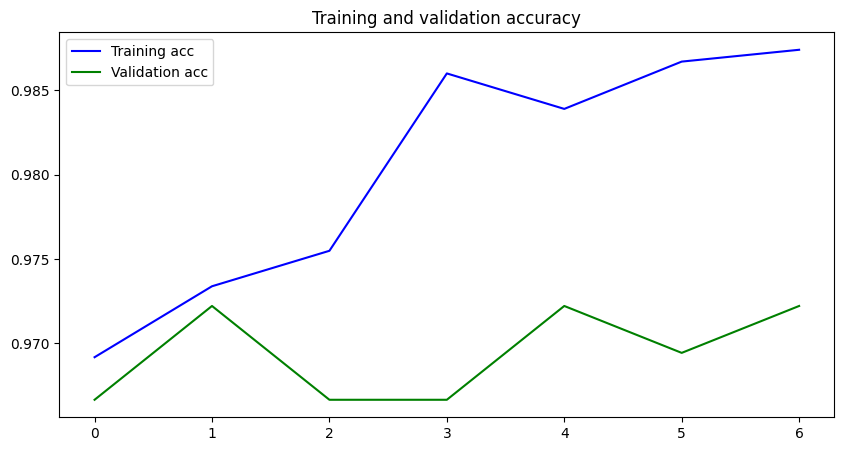

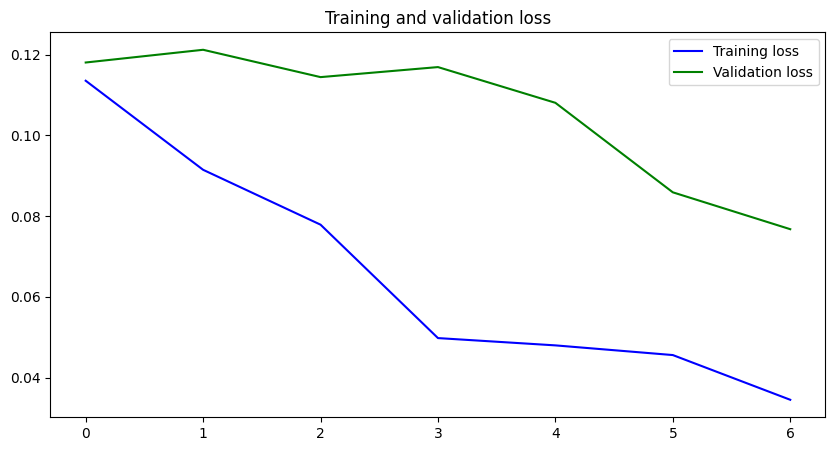

In [91]:
plot_history(history)

### Step 3: No Freeze Base model and full fine-turning

In [92]:
base_model.trainable = True

In [93]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizers.Adam(lr = LR_step3),
    metrics = ['accuracy']
)

In [94]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 10,
    callbacks = callbacks_list
)

Epoch 1/10
179/179 [==============================] - ETA: 0s - loss: 0.2853 - accuracy: 0.9125
Epoch 1: saving model to ./ManhModel/fine_tuning_best_model_step1.h5
179/179 [==============================] - 222s 659ms/step - loss: 0.2853 - accuracy: 0.9125 - val_loss: 0.4253 - val_accuracy: 0.9083
Epoch 2/10
179/179 [==============================] - ETA: 0s - loss: 0.3211 - accuracy: 0.9090
Epoch 2: saving model to ./ManhModel/fine_tuning_best_model_step1.h5
179/179 [==============================] - 113s 631ms/step - loss: 0.3211 - accuracy: 0.9090 - val_loss: 1.2161 - val_accuracy: 0.8389
Epoch 3/10
179/179 [==============================] - ETA: 0s - loss: 0.2177 - accuracy: 0.9349
Epoch 3: saving model to ./ManhModel/fine_tuning_best_model_step1.h5
179/179 [==============================] - 122s 680ms/step - loss: 0.2177 - accuracy: 0.9349 - val_loss: 0.3505 - val_accuracy: 0.9111
Epoch 4/10
179/179 [==============================] - ETA: 0s - loss: 0.2777 - accuracy: 0.9118
Epoc

In [96]:
scores = model.evaluate_generator(test_generator, verbose = 1)
print('Accuracy: %.2f%%' % (scores[1] * 100))

<ipython-input-96-cee19335592e>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, verbose = 1)


45/45 [==============================] - 5s 113ms/step - loss: 0.1974 - accuracy: 0.9583
Accuracy: 95.83%


### MANH - NOTE

In [97]:
model.save('./ManhModel/EfficientNet_model_step3.h5')
model.save_weights('./ManhModel/weights_EfficientNet_model_step3.hdf5')
# model.load_weights('best_model.hdf5')

In [100]:
from keras.models import load_model
EfficientNetB6 = load_model('./ManhModel/EfficientNet_model_step3.h5')

In [103]:
train_score = EfficientNetB6.evaluate(train_generator , steps= 32 , verbose = 1)
test_score = EfficientNetB6.evaluate(test_generator , steps = 32 , verbose = 1)

print(f'Train loss = {train_score[0] }')
print(f'Train Accuracy = {train_score[1]}')
print(f'Test loss = {test_score[0]}')
print(f'Test Accuracy = {test_score[1]}')

32/32 [==============================] - 3s 96ms/step - loss: 0.1642 - accuracy: 0.9688
Train loss = 0.0795665830373764
Train Accuracy = 0.9765625
Test loss = 0.16424047946929932
Test Accuracy = 0.96875


In [98]:
  base_model2 = efn.EfficientNetB6(
      weights = 'imagenet',
      include_top = False,
      input_shape = (250, 250, 3)
  )
  model2 = M.Sequential()
  model2.add(base_model)
  model2.add(L.GlobalAveragePooling2D())
  model2.add(L.Dense(15, activation = 'softmax'))
  model2.load_weights('./ManhModel/weights_EfficientNet_model_step3.hdf5')

## Final Score

In [47]:
from sklearn.metrics import accuracy_score

In [48]:
model.load_weights('best_model.hdf5')

ValueError: axes don't match array

In [ ]:
predictions = model.predict(test_generator, verbose = 1)
predictions = np.argmax(predictions, axis = -1)         # multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # flip k, v
predictions = [label_map[k] for k in predictions]

45/45 [==============================] - 9s 91ms/step


In [ ]:
filenames_with_dir = test_generator.filenames
submission = pd.DataFrame(
    {'Predict': predictions},
    columns = ['Predict'],
    index = filenames_with_dir
)
test_files.index = test_files['Id']
tmp_y = pd.concat(
    [submission['Predict'], test_files['Category']],
    axis = 1,
    sort = False
)
tmp_y.head(5)

,Predict,Category
jpg/image_00050.jpg,76,76
jpg/image_00138.jpg,76,76
jpg/image_02096.jpg,42,74
jpg/image_01158.jpg,73,73
jpg/image_01289.jpg,73,73


In [ ]:
print('Accuracy: %.2f%%' % (
    accuracy_score(tmp_y['Category'], tmp_y['Predict']) * 100
))

Accuracy: 87.50%


### confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

# tmp_y['Category'] là nhãn thực tế, tmp_y['Predict'] là dự đoán của mô hình
conf_matrix = confusion_matrix(tmp_y['Category'], tmp_y['Predict'])

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[10  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0 24  0  0  1  0  0  0  0  0  0  1  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 39  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0 32  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  1 20  1  0  0  0  0  0  0  0]
 [ 1  0  1  0  1  0  0 46  0  0  1  0  0  0  0]
 [ 0  0  0  0  3  1  0  0 23  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 23  0  0  0  0  0]
 [ 0  0  0  0  1  0  1  0  1  1 13  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 37  0  0  0]
 [ 0  0  2  0  0  1  0  0  0  0  1  2 11  0  0]
 [ 0  3  1  0  0  0  0  0  1  0  0  2  0  9  2]
 [ 0  3  0  0  0  0  0  1  0  0  0  2  0  0  7]]


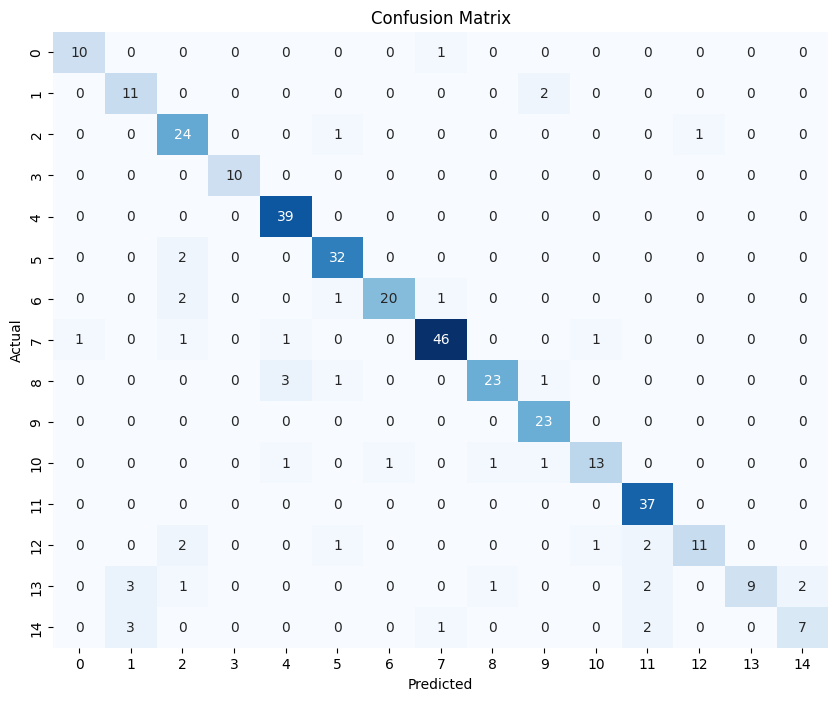

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Vẽ heatmap cho confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# In ra các trường hợp nhầm lẫn
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        if i != j and conf_matrix[i][j] > 0:
            print("Thực tế:", i, "Dự đoán:", j, "Số lượng:", conf_matrix[i][j])

Thực tế: 0 Dự đoán: 7 Số lượng: 1
Thực tế: 1 Dự đoán: 9 Số lượng: 2
Thực tế: 2 Dự đoán: 5 Số lượng: 1
Thực tế: 2 Dự đoán: 12 Số lượng: 1
Thực tế: 5 Dự đoán: 2 Số lượng: 2
Thực tế: 6 Dự đoán: 2 Số lượng: 2
Thực tế: 6 Dự đoán: 5 Số lượng: 1
Thực tế: 6 Dự đoán: 7 Số lượng: 1
Thực tế: 7 Dự đoán: 0 Số lượng: 1
Thực tế: 7 Dự đoán: 2 Số lượng: 1
Thực tế: 7 Dự đoán: 4 Số lượng: 1
Thực tế: 7 Dự đoán: 10 Số lượng: 1
Thực tế: 8 Dự đoán: 4 Số lượng: 3
Thực tế: 8 Dự đoán: 5 Số lượng: 1
Thực tế: 8 Dự đoán: 9 Số lượng: 1
Thực tế: 10 Dự đoán: 4 Số lượng: 1
Thực tế: 10 Dự đoán: 6 Số lượng: 1
Thực tế: 10 Dự đoán: 8 Số lượng: 1
Thực tế: 10 Dự đoán: 9 Số lượng: 1
Thực tế: 12 Dự đoán: 2 Số lượng: 2
Thực tế: 12 Dự đoán: 5 Số lượng: 1
Thực tế: 12 Dự đoán: 10 Số lượng: 1
Thực tế: 12 Dự đoán: 11 Số lượng: 2
Thực tế: 13 Dự đoán: 1 Số lượng: 3
Thực tế: 13 Dự đoán: 2 Số lượng: 1
Thực tế: 13 Dự đoán: 8 Số lượng: 1
Thực tế: 13 Dự đoán: 11 Số lượng: 2
Thực tế: 13 Dự đoán: 14 Số lượng: 2
Thực tế: 14 Dự đoán: 1 Số lượ

In [ ]:
# Tính tổng số lượng nhầm lẫn cho từng loại
errors_per_category = conf_matrix.sum(axis=1)

# Xây dựng bảng thống kê
error_table = []
for i, error_count in enumerate(errors_per_category):
    error_table.append({'Loại': i, 'Số lượng nhầm lẫn': error_count})

# Sắp xếp bảng thống kê theo số lượng nhầm lẫn giảm dần
error_table.sort(key=lambda x: x['Số lượng nhầm lẫn'], reverse=True)

# In bảng thống kê
print("Bảng thống kê số loại bị nhầm lẫn nhiều nhất từ cao đến thấp:")
for item in error_table:
    print("Loại:", item['Loại'], "- Số lượng nhầm lẫn:", item['Số lượng nhầm lẫn'])

Bảng thống kê số loại bị nhầm lẫn nhiều nhất từ cao đến thấp:
Loại: 7 - Số lượng nhầm lẫn: 50
Loại: 4 - Số lượng nhầm lẫn: 39
Loại: 11 - Số lượng nhầm lẫn: 37
Loại: 5 - Số lượng nhầm lẫn: 34
Loại: 8 - Số lượng nhầm lẫn: 28
Loại: 2 - Số lượng nhầm lẫn: 26
Loại: 6 - Số lượng nhầm lẫn: 24
Loại: 9 - Số lượng nhầm lẫn: 23
Loại: 13 - Số lượng nhầm lẫn: 18
Loại: 10 - Số lượng nhầm lẫn: 17
Loại: 12 - Số lượng nhầm lẫn: 17
Loại: 1 - Số lượng nhầm lẫn: 13
Loại: 14 - Số lượng nhầm lẫn: 13
Loại: 0 - Số lượng nhầm lẫn: 11
Loại: 3 - Số lượng nhầm lẫn: 10


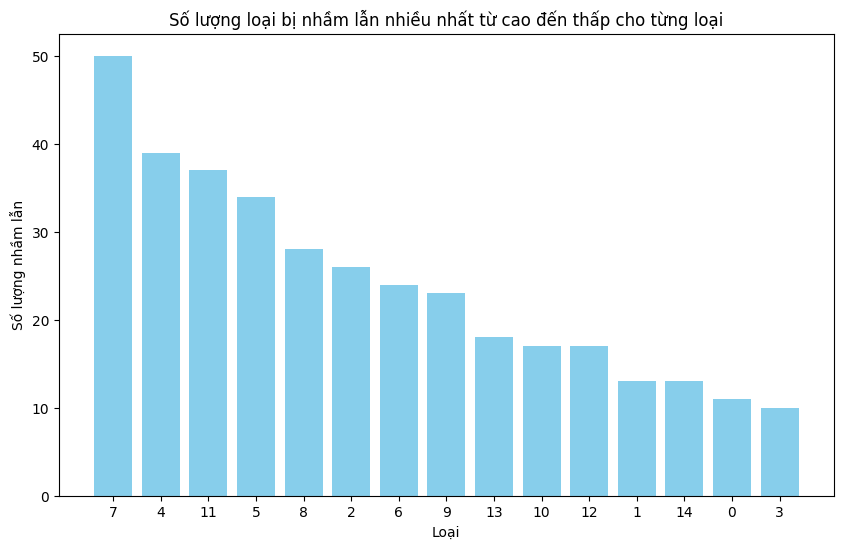

In [ ]:
# Lấy thông tin để vẽ biểu đồ
categories = [str(item['Loại']) for item in error_table[0:15]]
errors = [item['Số lượng nhầm lẫn'] for item in error_table[0:15]]

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.bar(categories, errors, color='skyblue')
plt.xlabel('Loại')
plt.ylabel('Số lượng nhầm lẫn')
plt.title('Số lượng loại bị nhầm lẫn nhiều nhất từ cao đến thấp cho từng loại')
plt.xticks(categories)
plt.show()


Category: ['48', '76', '42', '72', '89', '73', '81', '95', '88', '77', '37', '39', '83', '96', '74']

In [ ]:
print(categories)

['7', '4', '11', '5', '8', '2', '6', '9', '13', '10', '12', '1', '14', '0', '3']


Đây là các 15 loại nhầm lẫn nhiều nhất.
Công việc tiếp theo:
- Tính ra % chính xác của model efficientnetB6 với 15 loại này (dự đoán sẽ giảm so với 84% trên toàn bộ tập dữ liệu)
- Cắt bộ dữ liệu ra 15 loại
- Huấn luyện trên model Lenet5 với 37tr tham số, Alexnet, GoogleNet và thống kê kết quả

tính độ chính xác của 15 loại trên best model efficientNetB6:
- phải huấn luyện lại mô hình trên 15 loại này
- rồi đánh giá lại, mà huấn luyện rất mất thời gian, chắc là dùng lại model hiện giờ luôn.